# CLEAN BUILD FROM SCRATCH MIT-B2 on patches 768x768

In [2]:
CURRENT_FOLD = 3

# imports

In [3]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

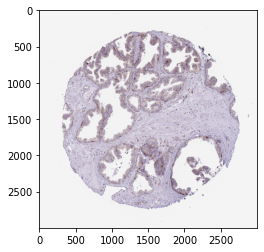

In [4]:
img1 = cv.imread('./../data/train_images/10044.tiff')[:, :, ::-1]
plt.imshow(img1)
plt.show()

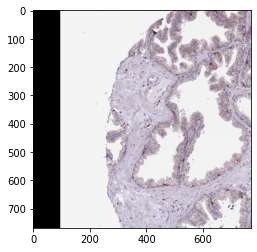

In [5]:
img2 = cv.imread('./../data/train_images_patches_768_overlap/10044_00010.png')[:, :, ::-1]
plt.imshow(img2)
plt.show()

In [6]:
# for fname in tqdm(glob('./../data/train_images_patches_768_overlap/*.png')):
#     img = cv.imread(fname)
#     cv.imwrite(fname, img[:, :, ::-1])

# data

In [7]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [9]:
from model_coat_daformer import *
from coat import *

## data 768

In [10]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_patches_768_overlap/'
TRAIN_MASKS_DIR = './../data/train_masks_patches_768_overlap/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 768 # размер патча


In [11]:
train_df = pd.read_csv(TRAIN_CSV)

In [12]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [13]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [14]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [15]:
def make_768_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('train_images_', 'train_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [16]:
train_df_768 = make_768_dataset(train_df)
print(train_df_768.shape)
train_df_768.head()

(8658, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
1,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
2,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
3,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
4,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4


In [17]:
train_df_768.iloc[0]['image']

'./../data/train_images_patches_768_overlap/10044_00013.png'

In [18]:
train_df_768.iloc[0]['mask']

'./../data/train_masks_patches_768_overlap/10044_00013.png'

In [19]:
train_df_768.iloc[0]['id']

10044

In [20]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [21]:
# mean = np.array([0.7720342, 0.74582646, 0.76392896])
# std = np.array([0.24745085, 0.26182273, 0.25782376])

In [22]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.5),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [23]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [24]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])

        data.update(upd_data)
        return data

In [25]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [26]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 768, 768])
image values:  0.0 0.9137255549430847


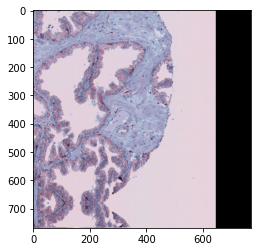

MASK
torch.Size([768, 768])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


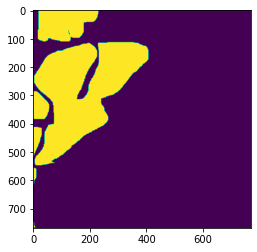

In [27]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [28]:
BATCH_SIZE = 5

In [29]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 768, 768])
image values:  0.027450982481241226 1.0


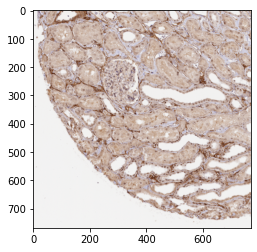

MASK
torch.Size([768, 768])
mask values:  tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


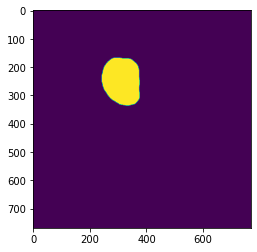

In [30]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# model

In [31]:
!nvidia-smi

Sun Aug 28 09:23:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   47C    P0    55W / 300W |  32031MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   48C    P0    55W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [32]:
device = 'cuda:2'
DEVICE = device

In [55]:
encoder = coat_parallel_small
decoder = daformer_conv3x3

model = Net(encoder=encoder, decoder=decoder, n_classes=6)

# setting up SWA process (due to shared weights)

In [56]:
swa_model = AveragedModel(model)

In [57]:
for el in ['./checkpoint_fold_3/coat-small_ep_030_dice_0.775207.pt',
           './checkpoint_fold_3/coat-small_ep_030_dice_0.775207.pt',
           './checkpoint_fold_3/coat-small_ep_030_dice_0.775207.pt']:
    model.load_state_dict(torch.load(el, map_location=device))
    swa_model.update_parameters(model, )

In [59]:
for key in model.state_dict().keys():
    print(key)

rgb.mean
rgb.std
encoder.cls_token1
encoder.cls_token2
encoder.cls_token3
encoder.cls_token4
encoder.patch_embed1.proj.weight
encoder.patch_embed1.proj.bias
encoder.patch_embed1.norm.weight
encoder.patch_embed1.norm.bias
encoder.patch_embed2.proj.weight
encoder.patch_embed2.proj.bias
encoder.patch_embed2.norm.weight
encoder.patch_embed2.norm.bias
encoder.patch_embed3.proj.weight
encoder.patch_embed3.proj.bias
encoder.patch_embed3.norm.weight
encoder.patch_embed3.norm.bias
encoder.patch_embed4.proj.weight
encoder.patch_embed4.proj.bias
encoder.patch_embed4.norm.weight
encoder.patch_embed4.norm.bias
encoder.cpe1.proj.weight
encoder.cpe1.proj.bias
encoder.cpe2.proj.weight
encoder.cpe2.proj.bias
encoder.cpe3.proj.weight
encoder.cpe3.proj.bias
encoder.cpe4.proj.weight
encoder.cpe4.proj.bias
encoder.crpe1.conv_list.0.weight
encoder.crpe1.conv_list.0.bias
encoder.crpe1.conv_list.1.weight
encoder.crpe1.conv_list.1.bias
encoder.crpe1.conv_list.2.weight
encoder.crpe1.conv_list.2.bias
encoder.crp

In [58]:
for key in model.state_dict().keys():
    W1 = model.state_dict()[key]
    W2 = swa_model.module.state_dict()[key]
    if not (torch.isclose(W1, W2).all().item()):
        print(key)
#     break

decoder.mlp.0.1.running_mean
decoder.mlp.0.1.running_var
decoder.mlp.0.1.num_batches_tracked
decoder.mlp.1.1.running_mean
decoder.mlp.1.1.running_var
decoder.mlp.1.1.num_batches_tracked
decoder.mlp.2.1.running_mean
decoder.mlp.2.1.running_var
decoder.mlp.2.1.num_batches_tracked
decoder.mlp.3.1.running_mean
decoder.mlp.3.1.running_var
decoder.mlp.3.1.num_batches_tracked
decoder.fuse.1.running_mean
decoder.fuse.1.running_var
decoder.fuse.1.num_batches_tracked
aux_heads_serial.0.1.running_mean
aux_heads_serial.0.1.running_var
aux_heads_serial.0.1.num_batches_tracked
aux_heads_serial.1.1.running_mean
aux_heads_serial.1.1.running_var
aux_heads_serial.1.1.num_batches_tracked
aux_heads_serial.2.1.running_mean
aux_heads_serial.2.1.running_var
aux_heads_serial.2.1.num_batches_tracked
aux_heads_serial.3.1.running_mean
aux_heads_serial.3.1.running_var
aux_heads_serial.3.1.num_batches_tracked


# calculating SWA try1

In [61]:
chkpts = []
for fname in sorted(glob('./checkpoint_fold_3/coat-small_ep_*_dice_*.pt')):
#     print(fname)
    bname = os.path.basename(fname)
    spt = bname.split('_')
    epoch = int(spt[2])
    dice = float(spt[4].rsplit('.', maxsplit=1)[0])
    print(epoch, dice)
    chkpts.append((fname, dice, epoch))

0 0.712504
1 0.759218
2 0.730074
3 0.754425
4 0.765127
5 0.766769
6 0.761697
7 0.74935
8 0.772269
9 0.778014
10 0.766472
11 0.741268
12 0.748736
13 0.774877
14 0.771367
15 0.78366
16 0.741167
17 0.74812
18 0.774618
19 0.762058
20 0.769214
21 0.768391
22 0.763882
23 0.765174
24 0.770897
25 0.754438
26 0.774086
27 0.766392
28 0.767239
29 0.766627
30 0.775207
31 0.768231
32 0.766436
33 0.774953
34 0.778614
35 0.766016
36 0.778027
37 0.771723
38 0.760358


In [62]:
chkpts = list(sorted(chkpts, key=lambda x: x[1]))

In [63]:
chkpts[-7:]

[('./checkpoint_fold_3/coat-small_ep_013_dice_0.774877.pt', 0.774877, 13),
 ('./checkpoint_fold_3/coat-small_ep_033_dice_0.774953.pt', 0.774953, 33),
 ('./checkpoint_fold_3/coat-small_ep_030_dice_0.775207.pt', 0.775207, 30),
 ('./checkpoint_fold_3/coat-small_ep_009_dice_0.778014.pt', 0.778014, 9),
 ('./checkpoint_fold_3/coat-small_ep_036_dice_0.778027.pt', 0.778027, 36),
 ('./checkpoint_fold_3/coat-small_ep_034_dice_0.778614.pt', 0.778614, 34),
 ('./checkpoint_fold_3/coat-small_ep_015_dice_0.783660.pt', 0.78366, 15)]

In [64]:
model.load_state_dict(torch.load(chkpts[-1][0], map_location=device))

<All keys matched successfully>

In [65]:
swa_model = AveragedModel(model)

In [66]:
for el in chkpts[-7:]:
    model.load_state_dict(torch.load(el[0], map_location=device))
    swa_model.update_parameters(model)

In [67]:
model.load_state_dict(torch.load(chkpts[-1][0], map_location=device))

<All keys matched successfully>

In [70]:
swa_state_dict = swa_model.state_dict()

In [72]:
for key in model.state_dict().keys():
    if 'num_batches_tracked' in key or \
        '.cpe.' in key or \
        '.crpe.' in key:
        print('replaced:', key)
        swa_state_dict['module.' + key] = model.state_dict()[key]

replaced: encoder.serial_blocks1.0.cpe.proj.weight
replaced: encoder.serial_blocks1.0.cpe.proj.bias
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.0.weight
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.0.bias
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.1.weight
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.1.bias
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.2.weight
replaced: encoder.serial_blocks1.0.factoratt_crpe.crpe.conv_list.2.bias
replaced: encoder.serial_blocks1.1.cpe.proj.weight
replaced: encoder.serial_blocks1.1.cpe.proj.bias
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.0.weight
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.0.bias
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.1.weight
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.1.bias
replaced: encoder.serial_blocks1.1.factoratt_crpe.crpe.conv_list.2.wei

replaced: encoder.parallel_blocks.3.factoratt_crpe3.crpe.conv_list.1.weight
replaced: encoder.parallel_blocks.3.factoratt_crpe3.crpe.conv_list.1.bias
replaced: encoder.parallel_blocks.3.factoratt_crpe3.crpe.conv_list.2.weight
replaced: encoder.parallel_blocks.3.factoratt_crpe3.crpe.conv_list.2.bias
replaced: encoder.parallel_blocks.3.factoratt_crpe4.crpe.conv_list.0.weight
replaced: encoder.parallel_blocks.3.factoratt_crpe4.crpe.conv_list.0.bias
replaced: encoder.parallel_blocks.3.factoratt_crpe4.crpe.conv_list.1.weight
replaced: encoder.parallel_blocks.3.factoratt_crpe4.crpe.conv_list.1.bias
replaced: encoder.parallel_blocks.3.factoratt_crpe4.crpe.conv_list.2.weight
replaced: encoder.parallel_blocks.3.factoratt_crpe4.crpe.conv_list.2.bias
replaced: encoder.parallel_blocks.4.factoratt_crpe2.crpe.conv_list.0.weight
replaced: encoder.parallel_blocks.4.factoratt_crpe2.crpe.conv_list.0.bias
replaced: encoder.parallel_blocks.4.factoratt_crpe2.crpe.conv_list.1.weight
replaced: encoder.parall

In [73]:
swa_model.load_state_dict(swa_state_dict)

<All keys matched successfully>

In [74]:
# model.load_state_dict(torch.load('./checkpoint_fold_3_SAM/mit-b2_ep_501_dice_0.772775.pt', map_location=device))

# don't forget to call this after training

In [75]:
# swa_model.load_state_dict(torch.load('..'))

In [76]:
device

'cuda:2'

In [77]:
swa_model = swa_model.to(device)

In [78]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index % 100 == 0:
            print(index)
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        
        image = self.transform(image=image)['image'].to(device)

        return {'image': image}

In [79]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [80]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], val_transform)
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False,
                          worker_init_fn=worker_init_fn,
                          num_workers=0
                         )

In [81]:
torch.optim.swa_utils.update_bn(loader_train, swa_model)

0


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


In [82]:
torch.save(swa_model.state_dict(), os.path.join(
                    './checkpoint_fold_{}'.format(CURRENT_FOLD), 
                    'coat-small-fold3_TOP_7_BEST.pt'
                )) 

In [ ]:
# no amp version

In [ ]:
for epoch in range(0, N_EPOCHS):
    criterion_image, criterion_aux = criterion_schedule(epoch)
    
    model.train()
    
    batch_train_loss = []
    
    for iteration, batch in enumerate(loader_train):
        global_it += 1
        
        batch['image'] = batch['image'].to(device)
        batch['mask' ] = batch['mask' ].to(device, dtype=torch.long)
#         batch['organ'] = batch['organ'].cuda()
        
        unfreeze_running_stats(model)

        output = model(batch)
        loss0      = criterion_image(output['out_logits'],   batch['mask'])
        loss_aux1  = criterion_aux  (output['aux1_logits'],  batch['mask']).mean()
        loss_aux2  = criterion_aux  (output['aux2_logits'],  batch['mask']).mean()
        loss = loss0 + 0.05 * loss_aux1 + 0.2 * loss_aux2
        
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        freeze_running_stats(model)  # <- this is the important line

        output = model(batch)
        loss0      = criterion_image(output['out_logits'],   batch['mask'])
        loss_aux1  = criterion_aux  (output['aux1_logits'],  batch['mask']).mean()
        loss_aux2  = criterion_aux  (output['aux2_logits'],  batch['mask']).mean()
        loss_act = loss0 + 0.05 * loss_aux1 + 0.2 * loss_aux2
            
        loss_act.backward()
        
        optimizer.second_step(zero_grad=True)
                 
        batch_train_loss.append(loss_act.item())          
        
        if global_it % VIRTUAL_BATCH_SIZE == 0:
            train_loss.append(np.mean(batch_train_loss))
            batch_train_loss = []
            lr_hist.append(optimizer.param_groups[0]['lr'])
            scheduler_warmup.step()
                    
        if global_it % (VIRTUAL_BATCH_SIZE * 5) == 0:
            log('==> Epoch {} ({:03d}/{:03d}) | loss: {:.5f}'.format(epoch, iteration, len(loader_train), loss.item()))


        if iteration % (VIRTUAL_BATCH_SIZE * 40) == 0:
            clear_output()

            plt.figure(figsize=(10, 5))
            plt.yscale('log')
            plt.plot(train_loss)
            plt.grid()
            plt.show()
              
            plt.figure(figsize=(10, 4))
            plt.plot(lr_hist, color='red')
            plt.title('lr')
            plt.grid()
            plt.show()
        
    if epoch > SWA_START:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        
    # val -------------------------------
    if epoch % 3 == 0:
        log('Eval')
        model.eval()

        with torch.no_grad():
            val_res = validate(val_df_id, model)
            val_dice = np.mean(val_res['dices'])
            log('DICE: {}'.format(val_dice))
            for key, value in val_res['by_organ'].items():
                log('{:20}: {:6.5f}'.format(key, np.mean(value)))

            torch.save(model.state_dict(), os.path.join(
                PTH_CKPT, 
                'mit-b2_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
            )) 
            if epoch > SWA_START:
                torch.save(swa_model.state_dict(), os.path.join(
                    PTH_CKPT, 
                    'mit-b2_swa_ep_{:03d}_dice_{:08.6f}.pt'.format(epoch, val_dice)
                )) 
            logfile.flush()
    